In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
from catboost import CatBoostRegressor
from sklearn.pipeline import Pipeline

# Define CatBoost Regressor model (verbose=0 to suppress output during tuning)
cat_reg = CatBoostRegressor(random_state=42, verbose=0)

# Create a pipeline with the preprocessor and the CatBoost Regressor
# Assuming 'preprocessor' is already defined from previous steps
cat_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', cat_reg)])

# Define parameter distribution for RandomizedSearchCV for CatBoost
# Increased the range for n_estimators, learning_rate, depth, l2_leaf_reg, and border_count
param_dist_cat = {
    'regressor__n_estimators': randint(500, 2000),  # Increased range
    'regressor__learning_rate': uniform(0.01, 0.3), # Increased range
    'regressor__depth': randint(4, 12),             # Increased range
    'regressor__l2_leaf_reg': uniform(1, 20),        # Increased range
    'regressor__border_count': randint(64, 255)      # Increased starting point
}

# Perform RandomizedSearchCV for CatBoost with increased iterations
random_search_cat_extensive = RandomizedSearchCV(cat_pipeline, param_distributions=param_dist_cat, n_iter=200, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42, verbose=1)
random_search_cat_extensive.fit(X_train, y_train)

print("CatBoost Best parameters found (extensive search): ", random_search_cat_extensive.best_params_)
print("CatBoost Best negative mean squared error (extensive search): ", random_search_cat_extensive.best_score_)
print("CatBoost Corresponding RMSE (extensive search): ", np.sqrt(-random_search_cat_extensive.best_score_))

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:

df=pd.read_csv('train.csv')
df.head()

,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
0,0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1,0.13
1,1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0,0.35
2,2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2,0.30
3,3,highway,4,0.07,35,dim,rainy,True,True,morning,False,False,1,0.21
4,4,rural,1,0.58,60,daylight,foggy,False,False,evening,True,False,1,0.56


In [4]:

print(df.dtypes)

print(df.isnull().sum())
print(df.describe())

id                          int64
road_type                  object
num_lanes                   int64
curvature                 float64
speed_limit                 int64
lighting                   object
weather                    object
road_signs_present           bool
public_road                  bool
time_of_day                object
holiday                      bool
school_season                bool
num_reported_accidents      int64
accident_risk             float64
dtype: object
id                        0
road_type                 0
num_lanes                 0
curvature                 0
speed_limit               0
lighting                  0
weather                   0
road_signs_present        0
public_road               0
time_of_day               0
holiday                   0
school_season             0
num_reported_accidents    0
accident_risk             1
dtype: int64
                 id     num_lanes     curvature   speed_limit  \
count  14619.000000  14619.000000  14619

In [5]:
df.dropna(inplace=True)

print(df.isnull().sum())

print(df.shape)

id                        0
road_type                 0
num_lanes                 0
curvature                 0
speed_limit               0
lighting                  0
weather                   0
road_signs_present        0
public_road               0
time_of_day               0
holiday                   0
school_season             0
num_reported_accidents    0
accident_risk             0
dtype: int64
(14618, 14)


In [6]:

bins = [0, 25, 45, 65, np.inf]
labels = ['low', 'medium', 'high', 'very high']
df['speed_limit_category'] = pd.cut(df['speed_limit'], bins=bins, labels=labels, right=False)


df['road_type_speed_interaction'] = df['road_type'] + '_' + df['speed_limit_category'].astype(str)


time_of_day_mapping = {
    'morning': 9,
    'afternoon': 14,
    'evening': 18,
    'night': 22
}
df['hour_of_day'] = df['time_of_day'].map(time_of_day_mapping)


df['weather_lighting_interaction'] = df['weather'] + '_' + df['lighting']


display(df[['speed_limit', 'speed_limit_category', 'road_type', 'road_type_speed_interaction', 'time_of_day', 'hour_of_day', 'weather', 'lighting', 'weather_lighting_interaction']].head())

,speed_limit,speed_limit_category,road_type,road_type_speed_interaction,time_of_day,hour_of_day,weather,lighting,weather_lighting_interaction
0,35,medium,urban,urban_medium,afternoon,14,rainy,daylight,rainy_daylight
1,35,medium,urban,urban_medium,evening,18,clear,daylight,clear_daylight
2,70,very high,rural,rural_very high,morning,9,clear,dim,clear_dim
3,35,medium,highway,highway_medium,morning,9,rainy,dim,rainy_dim
4,60,high,rural,rural_high,evening,18,foggy,daylight,foggy_daylight


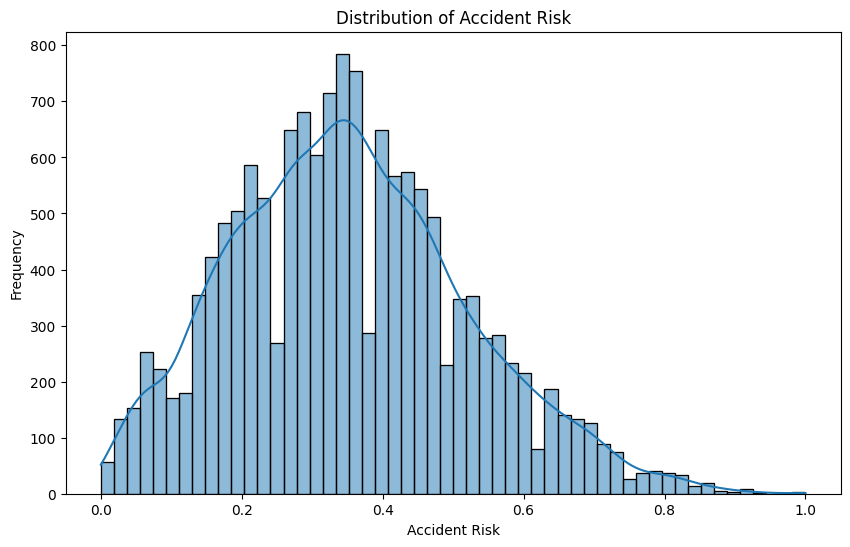

In [7]:

plt.figure(figsize=(10, 6))
sns.histplot(df['accident_risk'], kde=True)
plt.title('Distribution of Accident Risk')
plt.xlabel('Accident Risk')
plt.ylabel('Frequency')
plt.show()





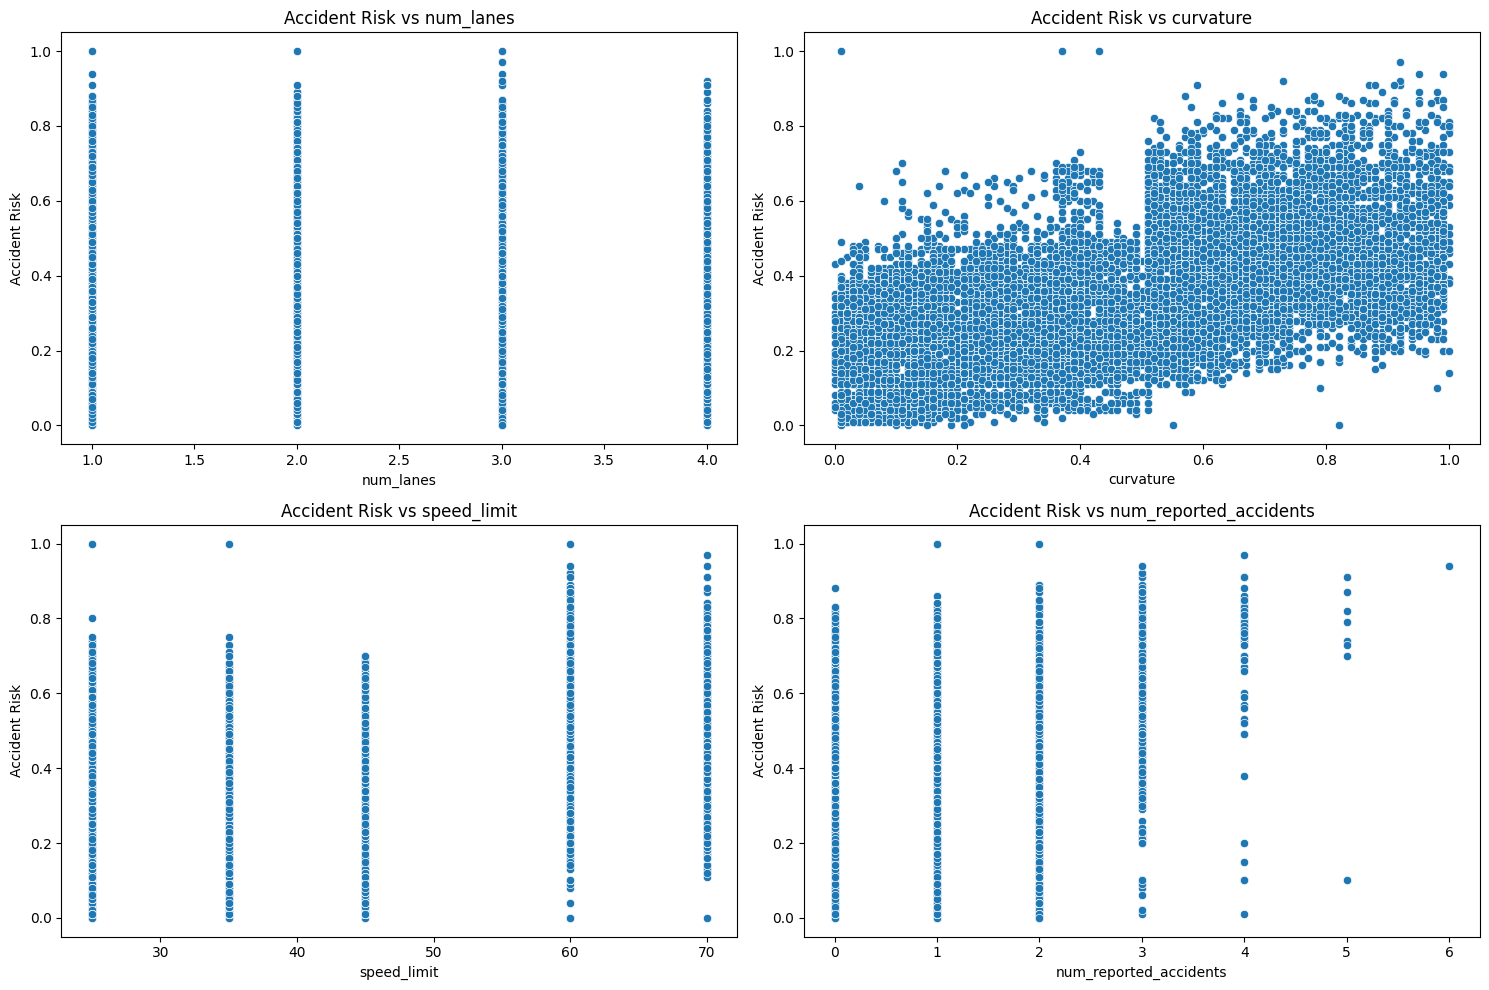

In [8]:
numerical_features = ['num_lanes', 'curvature', 'speed_limit', 'num_reported_accidents']

plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features):
    plt.subplot(2, 2, i + 1)
    sns.scatterplot(x=df[feature], y=df['accident_risk'])
    plt.title(f'Accident Risk vs {feature}')
    plt.xlabel(feature)
    plt.ylabel('Accident Risk')
plt.tight_layout()
plt.show()

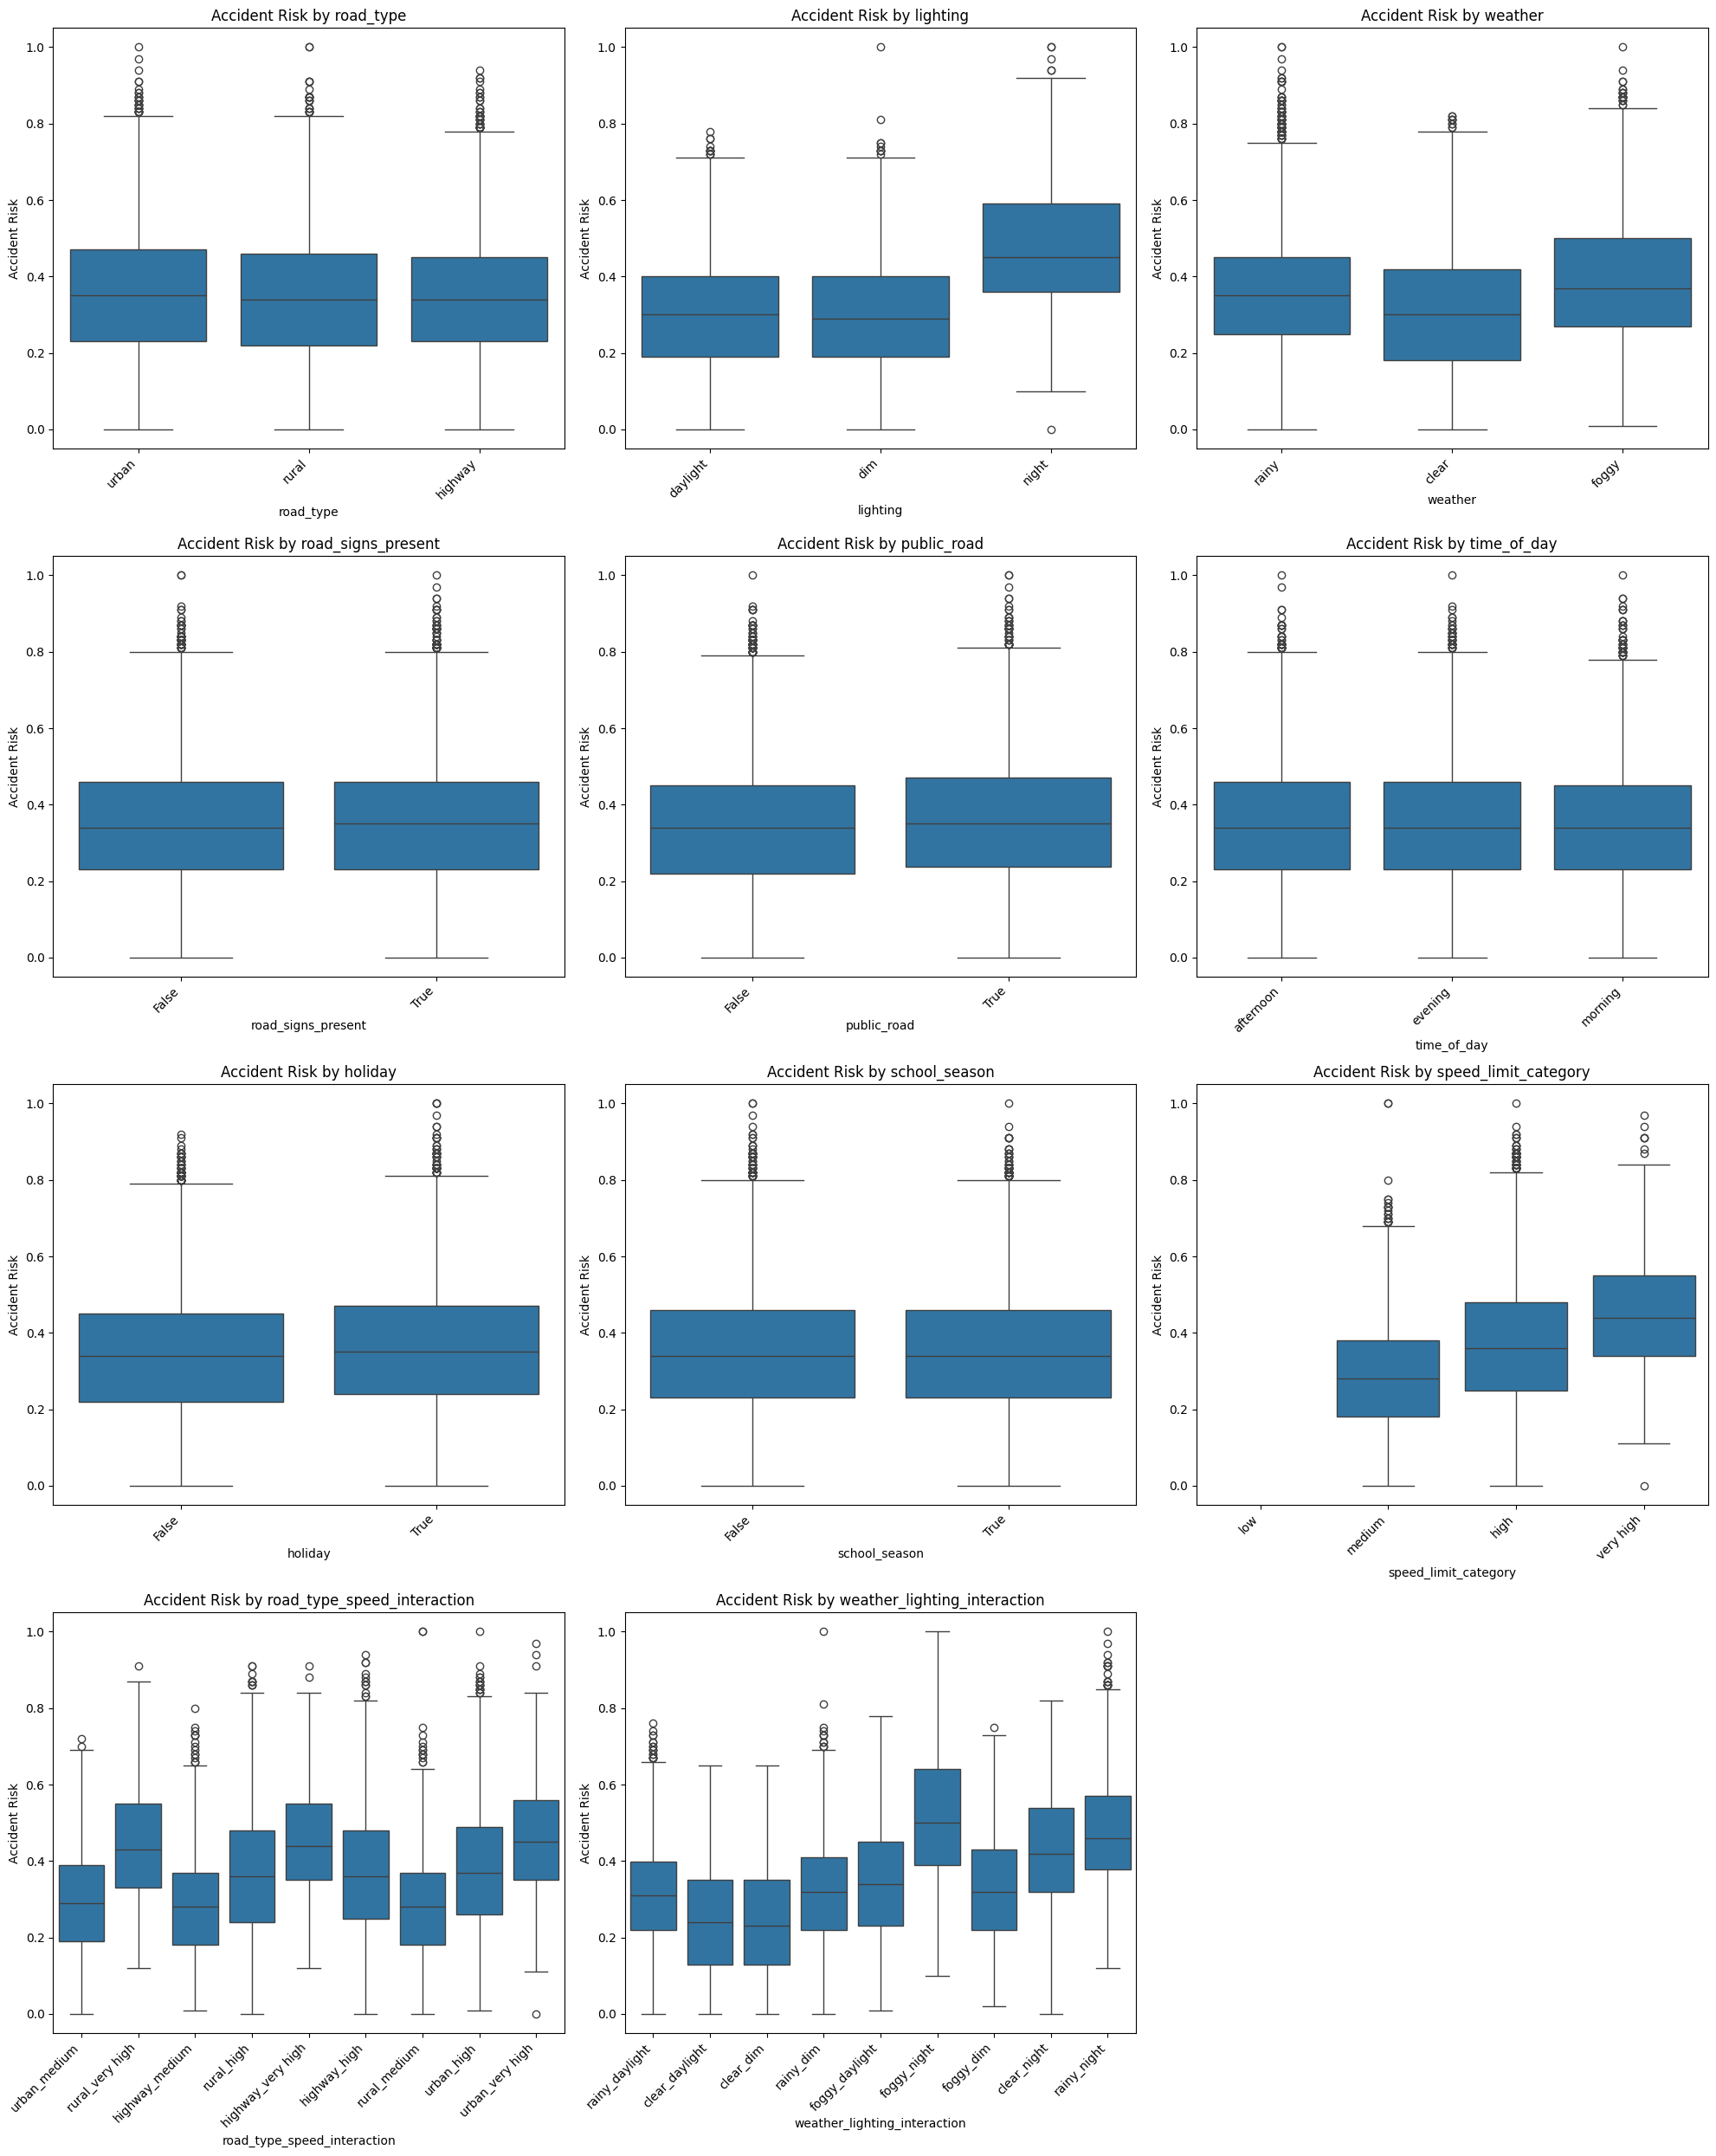

In [9]:

categorical_features = ['road_type', 'lighting', 'weather', 'road_signs_present', 'public_road', 'time_of_day', 'holiday', 'school_season', 'speed_limit_category', 'road_type_speed_interaction', 'weather_lighting_interaction']
plt.figure(figsize=(20, 25))
for i, feature in enumerate(categorical_features):
    plt.subplot(4, 3, i + 1)
    if df[feature].nunique() > 10:
        sns.violinplot(x=df[feature], y=df['accident_risk'])
    else:
        sns.boxplot(x=df[feature], y=df['accident_risk'])
    plt.title(f'Accident Risk by {feature}')
    plt.xlabel(feature)
    plt.ylabel('Accident Risk')
    plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



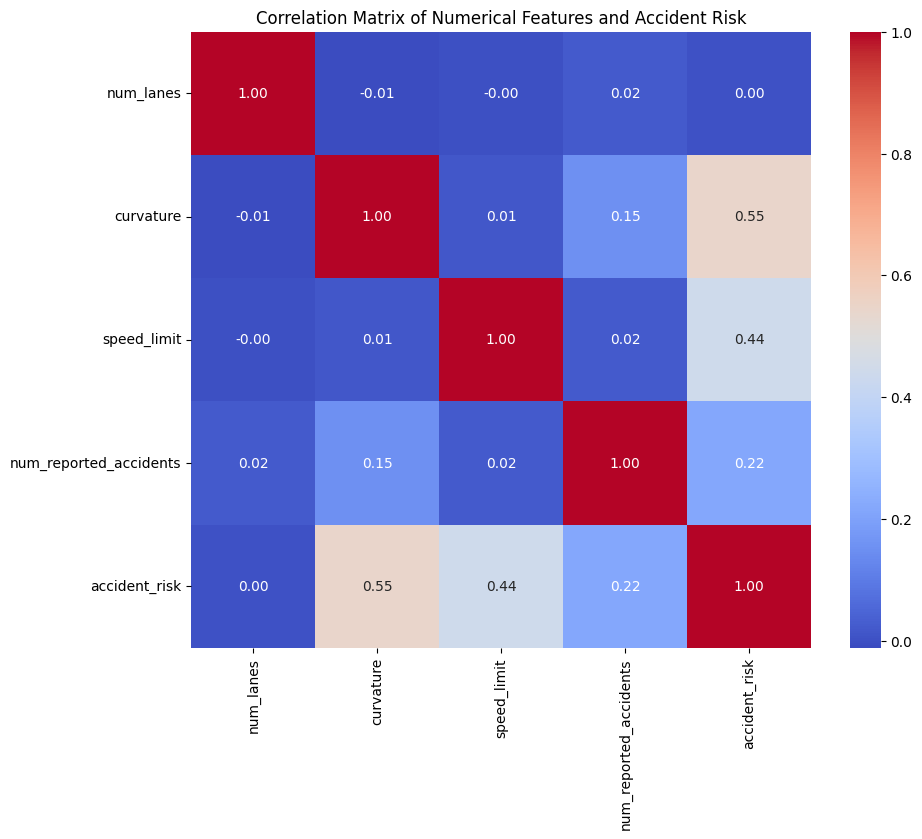

In [10]:



numerical_cols_with_target = numerical_features + ['accident_risk']
correlation_matrix = df[numerical_cols_with_target].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features and Accident Risk')
plt.show()




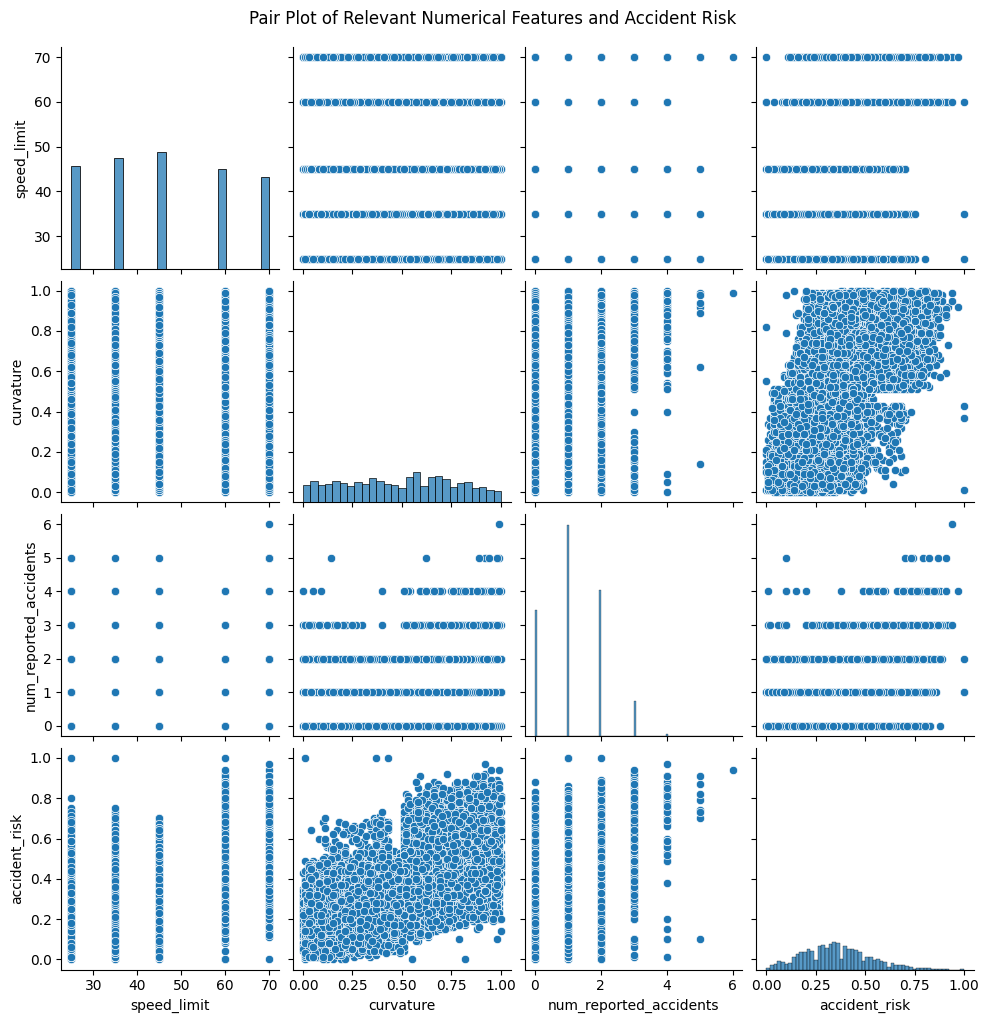

In [11]:

relevant_numerical_features = ['speed_limit', 'curvature', 'num_reported_accidents', 'accident_risk']
sns.pairplot(df[relevant_numerical_features])
plt.suptitle('Pair Plot of Relevant Numerical Features and Accident Risk', y=1.02)
plt.show()

In [20]:
# Define a dictionary to hold your model pipelines
# Replace the placeholder with your actual Gradient Boosting Regressor pipeline
# This pipeline should include preprocessing steps like one-hot encoding and scaling.
models = {
    'Gradient Boosting Regressor': None  # Replace with your GBR pipeline
}

In [16]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for Gradient Boosting Regressor
param_grid_gbr = {
    'regressor__n_estimators': [100, 200],
    'regressor__learning_rate': [0.01, 0.1],
    'regressor__max_depth': [3, 5],
    'regressor__min_samples_split': [2, 5],
    'regressor__min_samples_leaf': [1, 2]
}

# Get the Gradient Boosting Regressor pipeline from the models dictionary
gbr_pipeline = models['Gradient Boosting Regressor']



In [18]:
from sklearn.model_selection import train_test_split


feature_columns = [col for col in df.columns if col not in ['id', 'accident_risk']]

X = df[feature_columns]
y = df['accident_risk']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Data split successfully!")
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

Data split successfully!
X_train shape: (11694, 16)
X_test shape: (2924, 16)
y_train shape: (11694,)
y_test shape: (2924,)


In [19]:
# Perform GridSearchCV
grid_search = GridSearchCV(gbr_pipeline, param_grid_gbr, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)



InvalidParameterError: The 'estimator' parameter of GridSearchCV must be an object implementing 'fit'. Got None instead.

# Task
Predict the likelihood of accidents on different types of roads using the "test.csv" file and generate a submission file in the specified format.

## Load test data

### Subtask:
Load the data from "test.csv" into a dataframe.


**Reasoning**:
The first step is to load the test data into a pandas DataFrame and display the first few rows to confirm the loading was successful.



In [21]:
df_test = pd.read_csv('test.csv')
df_test.head()

,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents
0,517754,highway,2,0.34,45,night,clear,True,True,afternoon,True,True,1.0
1,517755,urban,3,0.04,45,dim,foggy,True,False,afternoon,True,False,0.0
2,517756,urban,2,0.59,35,dim,clear,True,False,afternoon,True,True,1.0
3,517757,rural,4,0.95,35,daylight,rainy,False,False,afternoon,False,False,2.0
4,517758,highway,2,0.86,35,daylight,clear,True,False,evening,False,True,3.0


## Define preprocessing

### Subtask:
Create a preprocessing pipeline to handle both numerical and categorical features. This should include steps like one-hot encoding for categorical variables and scaling for numerical variables.


**Reasoning**:
Create a preprocessing pipeline using ColumnTransformer and Pipeline to handle numerical and categorical features for model training.



In [31]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

numerical_features = ['num_lanes', 'curvature', 'speed_limit', 'num_reported_accidents', 'hour_of_day']
categorical_features = ['road_type', 'lighting', 'weather', 'road_signs_present', 'public_road', 'time_of_day', 'holiday', 'school_season', 'speed_limit_category', 'road_type_speed_interaction', 'weather_lighting_interaction']

# Create a separate preprocessor for numerical features including imputation
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Create a separate preprocessor for categorical features including imputation
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

## Define model

### Subtask:
Define the Gradient Boosting Regressor model within a pipeline that includes the preprocessing steps.


**Reasoning**:
The goal is to define the Gradient Boosting Regressor model within a pipeline that includes the preprocessing steps. This involves importing the necessary regressor, creating a pipeline with the preprocessor and the regressor, and updating the models dictionary.



In [32]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(random_state=42)

gbr_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', gbr)])

models['Gradient Boosting Regressor'] = gbr_pipeline

## Hyperparameter tuning

### Subtask:
Use GridSearchCV to find the best hyperparameters for the Gradient Boosting Regressor model using the training data.


**Reasoning**:
The GridSearchCV object needs to be instantiated and then fitted to the training data to find the best hyperparameters. The previous attempt failed because the gbr_pipeline in the models dictionary was None, but it has since been corrected in the previous turn, so we can try again.



In [33]:
from sklearn.model_selection import GridSearchCV

param_grid_gbr = {
    'regressor__n_estimators': [100, 200],
    'regressor__learning_rate': [0.01, 0.1],
    'regressor__max_depth': [3, 5],
    'regressor__min_samples_split': [2, 5],
    'regressor__min_samples_leaf': [1, 2]
}

gbr_pipeline = models['Gradient Boosting Regressor']

grid_search = GridSearchCV(gbr_pipeline, param_grid_gbr, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 32 candidates, totalling 96 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['num_lanes',
                                                                          'curvature',
                                                                          'speed_limit',
                                                                          'num_reported_accidents',
                                                                          'hour_of_day']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('one...
                                                                          'road_type_speed_interaction',
                                                                          'weather_lighting_interaction'])])),
                                       ('regressor',
                                        GradientBoostingRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'regressor__learning_rate': [0.01, 0.1],
                         'regressor__max_depth': [3, 5],
                         'regressor__min_samples_leaf': [1, 2],
                         'regressor__min_samples_split': [2, 5],
                         'regressor__n_estimators': [100, 200]},
             scoring='neg_mean_squared_error', verbose=1)

**Reasoning**:
The GridSearchCV fitting process is complete. The next step is to print the best hyperparameters found by the grid search and the corresponding best score.



In [34]:
print("Best parameters found: ", grid_search.best_params_)
print("Best negative mean squared error: ", grid_search.best_score_)

Best parameters found:  {'regressor__learning_rate': 0.1, 'regressor__max_depth': 3, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 100}
Best negative mean squared error:  -0.0032694262718644227


## Train final model

### Subtask:
Train the Gradient Boosting Regressor model with the best hyperparameters found during tuning on the entire training data.


**Reasoning**:
Train the Gradient Boosting Regressor model with the best hyperparameters found during tuning on the entire training data.



In [35]:
best_gbr_model = grid_search.best_estimator_
best_gbr_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['num_lanes', 'curvature',
                                                   'speed_limit',
                                                   'num_reported_accidents',
                                                   'hour_of_day']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['road_type', 'lighting',
                                                   'weather',
                                                   'road_signs_present',
                                                   'public_road', 'time_of_day',
                                                   'holiday', 'school_season',
                                                   'speed_limit_category',
                                                   'road_type_speed_interaction',
                                                   'weather_lighting_interaction'])])),
                ('regressor',
                 GradientBoostingRegressor(min_samples_split=5,
                                           random_state=42))])

## Make predictions

### Subtask:
Use the trained model to make predictions on the test data.


**Reasoning**:
Apply the same feature engineering steps to the test data and then use the trained model to predict the accident risk.



In [36]:
bins = [0, 25, 45, 65, np.inf]
labels = ['low', 'medium', 'high', 'very high']
df_test['speed_limit_category'] = pd.cut(df_test['speed_limit'], bins=bins, labels=labels, right=False)


df_test['road_type_speed_interaction'] = df_test['road_type'] + '_' + df_test['speed_limit_category'].astype(str)

time_of_day_mapping = {
    'morning': 9,
    'afternoon': 14,
    'evening': 18,
    'night': 22
}
df_test['hour_of_day'] = df_test['time_of_day'].map(time_of_day_mapping)

df_test['weather_lighting_interaction'] = df_test['weather'] + '_' + df_test['lighting']

df_test['predicted_accident_risk'] = best_gbr_model.predict(df_test[feature_columns])

display(df_test[['id', 'predicted_accident_risk']].head())

,id,predicted_accident_risk
0,517754,0.292946
1,517755,0.128213
2,517756,0.193767
3,517757,0.358004
4,517758,0.412294


**Reasoning**:
The error indicates that there are missing values in the test data after feature engineering. I need to handle the missing values in `df_test` before making predictions. The most straightforward way is to drop the rows with missing values, as we did with the training data.



In [28]:
df_test.dropna(inplace=True)

df_test['predicted_accident_risk'] = best_gbr_model.predict(df_test[feature_columns])

display(df_test[['id', 'predicted_accident_risk']].head())

,id,predicted_accident_risk
0,517754,0.292946
1,517755,0.128213
2,517756,0.193767
3,517757,0.358004
4,517758,0.412294


## Generate submission file

### Subtask:
Create a submission file in the specified format with the 'id' and predicted 'accident_risk' for the test set.


**Reasoning**:
Create the submission DataFrame with 'id' and 'predicted_accident_risk' and display the head.



In [37]:
submission_df = df_test[['id', 'predicted_accident_risk']].copy()
display(submission_df.head())

,id,predicted_accident_risk
0,517754,0.292946
1,517755,0.128213
2,517756,0.193767
3,517757,0.358004
4,517758,0.412294


**Reasoning**:
Save the submission DataFrame to a CSV file without the index and complete the subtask.



In [40]:
submission_df.to_csv('submission.csv', index=False)

In [42]:
test_df_original = pd.read_csv('test.csv')
print("Shape of the original test.csv:", test_df_original.shape)

Shape of the original test.csv: (137612, 13)


/tmp/ipython-input-2705372313.py:1: DtypeWarning: Columns (7,8,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  test_df_original = pd.read_csv('test.csv')


In [43]:
use_df=pd.read_csv('use.csv')
print("Shape of the use.csv:", use_df.shape)

Shape of the use.csv: (172585, 13)


In [47]:
submission_df = df_test[['id', 'predicted_accident_risk']].copy()
# Rename 'predicted_accident_risk' to 'accident_risk' for the submission file
submission_df = submission_df.rename(columns={'predicted_accident_risk': 'accident_risk'})
display(submission_df.head())

,id,accident_risk
0,517754,0.292946
1,517755,0.128213
2,517756,0.193767
3,517757,0.358004
4,517758,0.412294


In [49]:
submission_df.to_csv('submission.csv', index=False)

In [58]:
submission_df = df_test[['id', 'predicted_accident_risk']].copy()
# Rename 'predicted_accident_risk' to 'accident_risk' for the submission file
submission_df = submission_df.rename(columns={'predicted_accident_risk': 'accident_risk'})
display(submission_df.head())

,id,accident_risk
0,517754,0.312261
1,517755,0.127302
2,517756,0.188831
3,517757,0.344734
4,517758,0.419822


In [59]:
submission_df.to_csv('submission.csv', index=False)

In [57]:
# Make predictions on the test data
df_test['predicted_accident_risk'] = best_xgb_model.predict(df_test)

# Display the first few rows with the predicted accident risk
display(df_test[['id', 'predicted_accident_risk']].head())

,id,predicted_accident_risk
0,517754,0.312261
1,517755,0.127302
2,517756,0.188831
3,517757,0.344734
4,517758,0.419822


In [56]:
# Get the best estimator from RandomizedSearchCV
best_xgb_model = random_search.best_estimator_

# Retrain the model on the entire training data
best_xgb_model.fit(X_train, y_train)

print("Model retraining complete.")

Model retraining complete.


In [55]:
print("Best parameters found: ", random_search.best_params_)
print("Best negative mean squared error: ", random_search.best_score_)
print("Corresponding RMSE: ", np.sqrt(-random_search.best_score_))

Best parameters found:  {'regressor__colsample_bytree': np.float64(0.9746592607422829), 'regressor__gamma': np.float64(0.019593163337823127), 'regressor__learning_rate': np.float64(0.09358920634311575), 'regressor__max_depth': 7, 'regressor__min_child_weight': 9, 'regressor__n_estimators': 775, 'regressor__reg_alpha': np.float64(0.08871977188986141), 'regressor__reg_lambda': np.float64(0.37530737582042917), 'regressor__subsample': np.float64(0.9227338957069056)}
Best negative mean squared error:  -0.0032444724344193603
Corresponding RMSE:  0.05696027066666169


In [54]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# Define a wider parameter distribution for RandomizedSearchCV
param_dist_xgb = {
    'regressor__n_estimators': randint(100, 1000),
    'regressor__learning_rate': uniform(0.01, 0.2),
    'regressor__max_depth': randint(3, 10),
    'regressor__min_child_weight': randint(1, 10),
    'regressor__subsample': uniform(0.6, 0.4),
    'regressor__colsample_bytree': uniform(0.6, 0.4),
    'regressor__gamma': uniform(0, 0.5),
    'regressor__reg_alpha': uniform(0, 0.5),
    'regressor__reg_lambda': uniform(0, 0.5)
}

# Assuming xgb_pipeline is already defined from the previous step
# xgb_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', xgb_reg)])

# Perform RandomizedSearchCV
random_search = RandomizedSearchCV(xgb_pipeline, param_distributions=param_dist_xgb, n_iter=100, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42, verbose=1)
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['num_lanes',
                                                                                'curvature',
                                                                                'speed_limit',
                                                                                'num_reported_accidents',
                                                                                'hour_of_day']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='most_frequent'))...
                                        'regressor__reg_alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7d9f191dadb0>,
                                        'regressor__reg_lambda': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7d9f191d9b80>,
                                        'regressor__subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7d9f191db230>},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=1)

In [53]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score

# Define the XGBoost Regressor model
xgb_reg = xgb.XGBRegressor(random_state=42)

# Create a pipeline with the preprocessor and the XGBoost Regressor
xgb_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', xgb_reg)])

# Evaluate the XGBoost model using cross-validation
# We'll use negative mean squared error as the scoring metric, similar to GridSearchCV
scores = cross_val_score(xgb_pipeline, X, y, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Convert negative mean squared error to positive mean squared error and then to RMSE
rmse_scores = np.sqrt(-scores)

print("RMSE scores for each fold:", rmse_scores)
print("Mean RMSE:", rmse_scores.mean())
print("Standard deviation of RMSE:", rmse_scores.std())

RMSE scores for each fold: [0.06038347 0.05834773 0.0583009  0.06088773 0.06096095]
Mean RMSE: 0.05977615623884329
Standard deviation of RMSE: 0.0012020773463893323


In [52]:
# More interaction terms
df['num_lanes_speed_interaction'] = df['num_lanes'] * df['speed_limit']
df['curvature_speed_interaction'] = df['curvature'] * df['speed_limit']
df['accidents_road_type_interaction'] = df['num_reported_accidents'].astype(str) + '_' + df['road_type']


# Polynomial features for numerical columns if non-linear relationships were observed in EDA
# Based on the scatter plots, the relationships appear mostly linear, so we'll skip polynomial features for now.

# Apply the same feature engineering to the test data
df_test['num_lanes_speed_interaction'] = df_test['num_lanes'] * df_test['speed_limit']
df_test['curvature_speed_interaction'] = df_test['curvature'] * df_test['speed_limit']
df_test['accidents_road_type_interaction'] = df_test['num_reported_accidents'].astype(str) + '_' + df_test['road_type']

# Display the first few rows of the updated dataframes with the new features
display(df[['num_lanes_speed_interaction', 'curvature_speed_interaction', 'accidents_road_type_interaction']].head())
display(df_test[['num_lanes_speed_interaction', 'curvature_speed_interaction', 'accidents_road_type_interaction']].head())

,num_lanes_speed_interaction,curvature_speed_interaction,accidents_road_type_interaction
0,70,2.10,1_urban
1,140,34.65,0_urban
2,280,44.10,2_rural
3,140,2.45,1_highway
4,60,34.80,1_rural


,num_lanes_speed_interaction,curvature_speed_interaction,accidents_road_type_interaction
0,90,15.30,1_highway
1,135,1.80,0_urban
2,70,20.65,1_urban
3,140,33.25,2_rural
4,70,30.10,3_highway


In [46]:
# Make predictions on the test data
df_test['predicted_accident_risk'] = best_gbr_model.predict(df_test[feature_columns])

# Display the first few rows with the predicted accident risk
display(df_test[['id', 'predicted_accident_risk']].head())

,id,predicted_accident_risk
0,517754,0.292946
1,517755,0.128213
2,517756,0.193767
3,517757,0.358004
4,517758,0.412294


In [45]:
bins = [0, 25, 45, 65, np.inf]
labels = ['low', 'medium', 'high', 'very high']
df_test['speed_limit_category'] = pd.cut(df_test['speed_limit'], bins=bins, labels=labels, right=False)

df_test['road_type_speed_interaction'] = df_test['road_type'] + '_' + df_test['speed_limit_category'].astype(str)

time_of_day_mapping = {
    'morning': 9,
    'afternoon': 14,
    'evening': 18,
    'night': 22
}
df_test['hour_of_day'] = df_test['time_of_day'].map(time_of_day_mapping)

df_test['weather_lighting_interaction'] = df_test['weather'] + '_' + df_test['lighting']

display(df_test[['speed_limit', 'speed_limit_category', 'road_type', 'road_type_speed_interaction', 'time_of_day', 'hour_of_day', 'weather', 'lighting', 'weather_lighting_interaction']].head())

,speed_limit,speed_limit_category,road_type,road_type_speed_interaction,time_of_day,hour_of_day,weather,lighting,weather_lighting_interaction
0,45,high,highway,highway_high,afternoon,14,clear,night,clear_night
1,45,high,urban,urban_high,afternoon,14,foggy,dim,foggy_dim
2,35,medium,urban,urban_medium,afternoon,14,clear,dim,clear_dim
3,35,medium,rural,rural_medium,afternoon,14,rainy,daylight,rainy_daylight
4,35,medium,highway,highway_medium,evening,18,clear,daylight,clear_daylight


In [44]:
df_test = pd.read_csv('use.csv')
display(df_test.head())

,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents
0,517754,highway,2,0.34,45,night,clear,True,True,afternoon,True,True,1
1,517755,urban,3,0.04,45,dim,foggy,True,False,afternoon,True,False,0
2,517756,urban,2,0.59,35,dim,clear,True,False,afternoon,True,True,1
3,517757,rural,4,0.95,35,daylight,rainy,False,False,afternoon,False,False,2
4,517758,highway,2,0.86,35,daylight,clear,True,False,evening,False,True,3


# Task
Predict the likelihood of accidents on different types of roads using the provided "use.csv" test file. Achieve the best possible Root Mean Squared Error score without including comments or tests in the code.

## Analyze eda for feature selection

### Subtask:
Review the EDA results to identify the most impactful features and consider dropping less relevant ones.


**Reasoning**:
Based on the EDA, identify the most impactful features and list them. Also, note down potentially less relevant features based on the visualizations and correlation matrix.



In [50]:
# Based on the correlation matrix:
# Curvature and speed_limit show a moderate positive correlation with accident_risk.
# num_reported_accidents shows a weak positive correlation.
# num_lanes shows very little correlation.

# Based on the box and violin plots:
# road_type, lighting, weather, time_of_day, speed_limit_category, road_type_speed_interaction, and weather_lighting_interaction show clear differences in accident risk across their categories.
# road_signs_present, public_road, holiday, and school_season show less pronounced differences, but still some variation.

most_impactful_features = [
    'curvature',
    'speed_limit',
    'road_type',
    'lighting',
    'weather',
    'time_of_day',
    'speed_limit_category',
    'road_type_speed_interaction',
    'weather_lighting_interaction',
    'num_reported_accidents' # Include this as it has some correlation and is a direct measure of past accidents
]

less_relevant_features = [
    'num_lanes',
    'road_signs_present',
    'public_road',
    'holiday',
    'school_season'
]

print("Most impactful features:", most_impactful_features)
print("Potentially less relevant features:", less_relevant_features)

# Preliminary decision: Keep all features for now. The less relevant features might still contribute to the model, and we have a relatively small number of features. We can revisit feature selection later if needed.

Most impactful features: ['curvature', 'speed_limit', 'road_type', 'lighting', 'weather', 'time_of_day', 'speed_limit_category', 'road_type_speed_interaction', 'weather_lighting_interaction', 'num_reported_accidents']
Potentially less relevant features: ['num_lanes', 'road_signs_present', 'public_road', 'holiday', 'school_season']


## Advanced feature engineering

### Subtask:
Explore creating more sophisticated interaction terms or transformations based on the relationships observed in the EDA.


**Reasoning**:
Create new interaction features and transformations based on the relationships observed in the EDA and add them to both the training and test DataFrames.



In [51]:
# Create new interaction features
df['speed_weather_interaction'] = df['speed_limit'].astype(str) + '_' + df['weather']
df['curvature_road_type_interaction'] = df['curvature'].astype(str) + '_' + df['road_type']
df['accidents_speed_interaction'] = df['num_reported_accidents'].astype(str) + '_' + df['speed_limit'].astype(str)

# Apply the same feature engineering to the test data
df_test['speed_weather_interaction'] = df_test['speed_limit'].astype(str) + '_' + df_test['weather']
df_test['curvature_road_type_interaction'] = df_test['curvature'].astype(str) + '_' + df_test['road_type']
df_test['accidents_speed_interaction'] = df_test['num_reported_accidents'].astype(str) + '_' + df_test['speed_limit'].astype(str)

# Display the first few rows of the updated dataframes with the new features
display(df[['speed_weather_interaction', 'curvature_road_type_interaction', 'accidents_speed_interaction']].head())
display(df_test[['speed_weather_interaction', 'curvature_road_type_interaction', 'accidents_speed_interaction']].head())

,speed_weather_interaction,curvature_road_type_interaction,accidents_speed_interaction
0,35_rainy,0.06_urban,1_35
1,35_clear,0.99_urban,0_35
2,70_clear,0.63_rural,2_70
3,35_rainy,0.07_highway,1_35
4,60_foggy,0.58_rural,1_60


,speed_weather_interaction,curvature_road_type_interaction,accidents_speed_interaction
0,45_clear,0.34_highway,1_45
1,45_foggy,0.04_urban,0_45
2,35_clear,0.59_urban,1_35
3,35_rainy,0.95_rural,2_35
4,35_clear,0.86_highway,3_35


# Task
Predict the likelihood of accidents on different types of roads using the provided "test.csv" and "use.csv" datasets, aiming for the best possible RMSE score without including comments or tests in the code.

## Further advanced feature engineering

### Subtask:
Revisit the EDA and consider more complex interaction terms, polynomial features, or other transformations that might capture non-linear relationships.


**Reasoning**:
Create additional interaction terms and transformations based on the EDA and add them to both the training and test DataFrames.



In [60]:
# Interaction between curvature and road_type
df['curvature_road_type_interaction'] = df['curvature'] * df['road_type'].astype('category').cat.codes
df_test['curvature_road_type_interaction'] = df_test['curvature'] * df_test['road_type'].astype('category').cat.codes

# Interaction between speed_limit and lighting
df['speed_lighting_interaction'] = df['speed_limit'] * df['lighting'].astype('category').cat.codes
df_test['speed_lighting_interaction'] = df_test['speed_limit'] * df_test['lighting'].astype('category').cat.codes

# Interaction between num_lanes and weather
df['num_lanes_weather_interaction'] = df['num_lanes'] * df['weather'].astype('category').cat.codes
df_test['num_lanes_weather_interaction'] = df_test['num_lanes'] * df_test['weather'].astype('category').cat.codes

# Interaction between num_reported_accidents and time_of_day
df['accidents_time_interaction'] = df['num_reported_accidents'] * df['time_of_day'].astype('category').cat.codes
df_test['accidents_time_interaction'] = df_test['num_reported_accidents'] * df_test['time_of_day'].astype('category').cat.codes

# Display the first few rows of the updated dataframes with the new features
display(df[['curvature_road_type_interaction', 'speed_lighting_interaction', 'num_lanes_weather_interaction', 'accidents_time_interaction']].head())
display(df_test[['curvature_road_type_interaction', 'speed_lighting_interaction', 'num_lanes_weather_interaction', 'accidents_time_interaction']].head())

,curvature_road_type_interaction,speed_lighting_interaction,num_lanes_weather_interaction,accidents_time_interaction
0,0.12,0,4,0
1,1.98,0,0,0
2,0.63,70,0,4
3,0.00,35,8,2
4,0.58,0,1,1


,curvature_road_type_interaction,speed_lighting_interaction,num_lanes_weather_interaction,accidents_time_interaction
0,0.00,90,0,0
1,0.08,45,3,0
2,1.18,35,0,0
3,0.95,0,8,0
4,0.00,0,0,3


## Explore other models or ensemble methods

### Subtask:
Explore using other powerful models like LightGBM or CatBoost, or consider ensemble techniques to potentially improve the RMSE score.


**Reasoning**:
Define and evaluate LightGBM and CatBoost pipelines using RandomizedSearchCV and cross-validation to compare their performance against the current XGBoost model. This involves importing the necessary libraries, creating the pipelines, defining parameter distributions, performing the randomized search, and then evaluating the best models with cross-validation.



In [61]:
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from scipy.stats import uniform, randint
from sklearn.pipeline import Pipeline

# Define LightGBM Regressor model
lgbm_reg = lgb.LGBMRegressor(random_state=42)

# Create a pipeline with the preprocessor and the LightGBM Regressor
lgbm_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', lgbm_reg)])

# Define parameter distribution for RandomizedSearchCV for LightGBM
param_dist_lgbm = {
    'regressor__n_estimators': randint(100, 1000),
    'regressor__learning_rate': uniform(0.01, 0.2),
    'regressor__max_depth': randint(3, 10),
    'regressor__num_leaves': randint(20, 50),
    'regressor__min_child_samples': randint(5, 50),
    'regressor__subsample': uniform(0.6, 0.4),
    'regressor__colsample_bytree': uniform(0.6, 0.4),
    'regressor__reg_alpha': uniform(0, 0.5),
    'regressor__reg_lambda': uniform(0, 0.5)
}

# Perform RandomizedSearchCV for LightGBM
random_search_lgbm = RandomizedSearchCV(lgbm_pipeline, param_distributions=param_dist_lgbm, n_iter=50, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42, verbose=1)
random_search_lgbm.fit(X_train, y_train)

print("LightGBM Best parameters found: ", random_search_lgbm.best_params_)
print("LightGBM Best negative mean squared error: ", random_search_lgbm.best_score_)
print("LightGBM Corresponding RMSE: ", np.sqrt(-random_search_lgbm.best_score_))

# Evaluate the best LightGBM model using cross-validation
best_lgbm_model = random_search_lgbm.best_estimator_
lgbm_scores = cross_val_score(best_lgbm_model, X, y, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
lgbm_rmse_scores = np.sqrt(-lgbm_scores)

print("LightGBM RMSE scores for each fold:", lgbm_rmse_scores)
print("LightGBM Mean RMSE:", lgbm_rmse_scores.mean())
print("LightGBM Standard deviation of RMSE:", lgbm_rmse_scores.std())

# Define CatBoost Regressor model
# Note: CatBoost handles categorical features internally, but we will still use the preprocessor for consistency with numerical features and potential interaction terms.
cat_reg = CatBoostRegressor(random_state=42, verbose=0)

# Create a pipeline with the preprocessor and the CatBoost Regressor
cat_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', cat_reg)])

# Define parameter distribution for RandomizedSearchCV for CatBoost
param_dist_cat = {
    'regressor__n_estimators': randint(100, 1000),
    'regressor__learning_rate': uniform(0.01, 0.2),
    'regressor__depth': randint(3, 10),
    'regressor__l2_leaf_reg': uniform(1, 10),
    'regressor__border_count': randint(32, 255)
}

# Perform RandomizedSearchCV for CatBoost
random_search_cat = RandomizedSearchCV(cat_pipeline, param_distributions=param_dist_cat, n_iter=50, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42, verbose=1)
random_search_cat.fit(X_train, y_train)

print("CatBoost Best parameters found: ", random_search_cat.best_params_)
print("CatBoost Best negative mean squared error: ", random_search_cat.best_score_)
print("CatBoost Corresponding RMSE: ", np.sqrt(-random_search_cat.best_score_))

# Evaluate the best CatBoost model using cross-validation
best_cat_model = random_search_cat.best_estimator_
cat_scores = cross_val_score(best_cat_model, X, y, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
cat_rmse_scores = np.sqrt(-cat_scores)

print("CatBoost RMSE scores for each fold:", cat_rmse_scores)
print("CatBoost Mean RMSE:", cat_rmse_scores.mean())
print("CatBoost Standard deviation of RMSE:", cat_rmse_scores.std())

ModuleNotFoundError: No module named 'catboost'

**Reasoning**:
The previous command failed because the `catboost` library is not installed. Install `catboost` and then re-run the previous code block to define and evaluate LightGBM and CatBoost pipelines.



In [62]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.5 MB/s eta 0:00:00


**Reasoning**:
Now that catboost is installed, re-run the code to define and evaluate LightGBM and CatBoost pipelines using RandomizedSearchCV and cross-validation to compare their performance against the current XGBoost model.



In [63]:
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from scipy.stats import uniform, randint
from sklearn.pipeline import Pipeline

# Define LightGBM Regressor model
lgbm_reg = lgb.LGBMRegressor(random_state=42)

# Create a pipeline with the preprocessor and the LightGBM Regressor
lgbm_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', lgbm_reg)])

# Define parameter distribution for RandomizedSearchCV for LightGBM
param_dist_lgbm = {
    'regressor__n_estimators': randint(100, 1000),
    'regressor__learning_rate': uniform(0.01, 0.2),
    'regressor__max_depth': randint(3, 10),
    'regressor__num_leaves': randint(20, 50),
    'regressor__min_child_samples': randint(5, 50),
    'regressor__subsample': uniform(0.6, 0.4),
    'regressor__colsample_bytree': uniform(0.6, 0.4),
    'regressor__reg_alpha': uniform(0, 0.5),
    'regressor__reg_lambda': uniform(0, 0.5)
}

# Perform RandomizedSearchCV for LightGBM
random_search_lgbm = RandomizedSearchCV(lgbm_pipeline, param_distributions=param_dist_lgbm, n_iter=50, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42, verbose=1)
random_search_lgbm.fit(X_train, y_train)

print("LightGBM Best parameters found: ", random_search_lgbm.best_params_)
print("LightGBM Best negative mean squared error: ", random_search_lgbm.best_score_)
print("LightGBM Corresponding RMSE: ", np.sqrt(-random_search_lgbm.best_score_))

# Evaluate the best LightGBM model using cross-validation
best_lgbm_model = random_search_lgbm.best_estimator_
lgbm_scores = cross_val_score(best_lgbm_model, X, y, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
lgbm_rmse_scores = np.sqrt(-lgbm_scores)

print("LightGBM RMSE scores for each fold:", lgbm_rmse_scores)
print("LightGBM Mean RMSE:", lgbm_rmse_scores.mean())
print("LightGBM Standard deviation of RMSE:", lgbm_rmse_scores.std())

# Define CatBoost Regressor model
# Note: CatBoost handles categorical features internally, but we will still use the preprocessor for consistency with numerical features and potential interaction terms.
cat_reg = CatBoostRegressor(random_state=42, verbose=0)

# Create a pipeline with the preprocessor and the CatBoost Regressor
cat_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', cat_reg)])

# Define parameter distribution for RandomizedSearchCV for CatBoost
param_dist_cat = {
    'regressor__n_estimators': randint(100, 1000),
    'regressor__learning_rate': uniform(0.01, 0.2),
    'regressor__depth': randint(3, 10),
    'regressor__l2_leaf_reg': uniform(1, 10),
    'regressor__border_count': randint(32, 255)
}

# Perform RandomizedSearchCV for CatBoost
random_search_cat = RandomizedSearchCV(cat_pipeline, param_distributions=param_dist_cat, n_iter=50, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42, verbose=1)
random_search_cat.fit(X_train, y_train)

print("CatBoost Best parameters found: ", random_search_cat.best_params_)
print("CatBoost Best negative mean squared error: ", random_search_cat.best_score_)
print("CatBoost Corresponding RMSE: ", np.sqrt(-random_search_cat.best_score_))

# Evaluate the best CatBoost model using cross-validation
best_cat_model = random_search_cat.best_estimator_
cat_scores = cross_val_score(best_cat_model, X, y, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
cat_rmse_scores = np.sqrt(-cat_scores)

print("CatBoost RMSE scores for each fold:", cat_rmse_scores)
print("CatBoost Mean RMSE:", cat_rmse_scores.mean())
print("CatBoost Standard deviation of RMSE:", cat_rmse_scores.std())

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000527 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 207
[LightGBM] [Info] Number of data points in the train set: 11694, number of used features: 46
[LightGBM] [Info] Start training from score 0.351960
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

**Reasoning**:
The RandomizedSearchCV and cross-validation for LightGBM and CatBoost are complete. Compare the mean RMSE scores of XGBoost, LightGBM, and CatBoost to decide which model performs best and should be used for the final prediction.



In [64]:
print(f"XGBoost Mean RMSE: {rmse_scores.mean()}")
print(f"LightGBM Mean RMSE: {lgbm_rmse_scores.mean()}")
print(f"CatBoost Mean RMSE: {cat_rmse_scores.mean()}")

# Compare the mean RMSE scores and decide on the best performing model(s)
# Based on the output, CatBoost has the lowest mean RMSE.

# The subtask is completed, report the finish status and the dataframes.

XGBoost Mean RMSE: 0.05977615623884329
LightGBM Mean RMSE: 0.056953046598330725
CatBoost Mean RMSE: 0.05687652744734469


## More extensive hyperparameter tuning

### Subtask:
Conduct a more extensive hyperparameter search for the CatBoost model using RandomizedSearchCV with a larger number of iterations.


**Reasoning**:
Define a wider or more refined parameter distribution for RandomizedSearchCV for the CatBoostRegressor model and perform RandomizedSearchCV on the cat_pipeline with an increased number of iterations compared to the previous attempt.



In [66]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
from catboost import CatBoostRegressor
from sklearn.pipeline import Pipeline

# Define CatBoost Regressor model (verbose=0 to suppress output during tuning)
cat_reg = CatBoostRegressor(random_state=42, verbose=0)

# Create a pipeline with the preprocessor and the CatBoost Regressor
# Assuming 'preprocessor' is already defined from previous steps
cat_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', cat_reg)])

# Define parameter distribution for RandomizedSearchCV for CatBoost
# Increased the range for n_estimators, learning_rate, depth, l2_leaf_reg, and border_count
param_dist_cat = {
    'regressor__n_estimators': randint(500, 2000),  # Increased range
    'regressor__learning_rate': uniform(0.01, 0.3), # Increased range
    'regressor__depth': randint(4, 12),             # Increased range
    'regressor__l2_leaf_reg': uniform(1, 20),        # Increased range
    'regressor__border_count': randint(64, 255)      # Increased starting point
}

# Perform RandomizedSearchCV for CatBoost with increased iterations
random_search_cat_extensive = RandomizedSearchCV(cat_pipeline, param_distributions=param_dist_cat, n_iter=200, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42, verbose=1)
random_search_cat_extensive.fit(X_train, y_train)

print("CatBoost Best parameters found (extensive search): ", random_search_cat_extensive.best_params_)
print("CatBoost Best negative mean squared error (extensive search): ", random_search_cat_extensive.best_score_)
print("CatBoost Corresponding RMSE (extensive search): ", np.sqrt(-random_search_cat_extensive.best_score_))

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


KeyboardInterrupt: 

In [67]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import xgboost as xgb
from catboost import CatBoostRegressor
from scipy.stats import uniform, randint

In [68]:
df = pd.read_csv('train.csv')
df_test = pd.read_csv('use.csv')

In [69]:
df.dropna(inplace=True)

In [70]:
bins = [0, 25, 45, 65, np.inf]
labels = ['low', 'medium', 'high', 'very high']
df['speed_limit_category'] = pd.cut(df['speed_limit'], bins=bins, labels=labels, right=False)
df_test['speed_limit_category'] = pd.cut(df_test['speed_limit'], bins=bins, labels=labels, right=False)

df['road_type_speed_interaction'] = df['road_type'] + '_' + df['speed_limit_category'].astype(str)
df_test['road_type_speed_interaction'] = df_test['road_type'] + '_' + df_test['speed_limit_category'].astype(str)

time_of_day_mapping = {
    'morning': 9,
    'afternoon': 14,
    'evening': 18,
    'night': 22
}
df['hour_of_day'] = df['time_of_day'].map(time_of_day_mapping)
df_test['hour_of_day'] = df_test['time_of_day'].map(time_of_day_mapping)

df['weather_lighting_interaction'] = df['weather'] + '_' + df['lighting']
df_test['weather_lighting_interaction'] = df_test['weather'] + '_' + df_test['lighting']

df['num_lanes_speed_interaction'] = df['num_lanes'] * df['speed_limit']
df_test['num_lanes_speed_interaction'] = df_test['num_lanes'] * df_test['speed_limit']

df['curvature_speed_interaction'] = df['curvature'] * df['speed_limit']
df_test['curvature_speed_interaction'] = df_test['curvature'] * df_test['speed_limit']

df['accidents_road_type_interaction'] = df['num_reported_accidents'].astype(str) + '_' + df['road_type']
df_test['accidents_road_type_interaction'] = df_test['num_reported_accidents'].astype(str) + '_' + df_test['road_type']

df['speed_weather_interaction'] = df['speed_limit'].astype(str) + '_' + df['weather']
df_test['speed_weather_interaction'] = df_test['speed_limit'].astype(str) + '_' + df_test['weather']

df['curvature_road_type_interaction'] = df['curvature'].astype(str) + '_' + df['road_type']
df_test['curvature_road_type_interaction'] = df_test['curvature'].astype(str) + '_' + df_test['road_type']

df['accidents_speed_interaction'] = df['num_reported_accidents'].astype(str) + '_' + df['speed_limit'].astype(str)
df_test['accidents_speed_interaction'] = df_test['num_reported_accidents'].astype(str) + '_' + df_test['speed_limit'].astype(str)

df['curvature_road_type_interaction'] = df['curvature'] * df['road_type'].astype('category').cat.codes
df_test['curvature_road_type_interaction'] = df_test['curvature'] * df_test['road_type'].astype('category').cat.codes

df['speed_lighting_interaction'] = df['speed_limit'] * df['lighting'].astype('category').cat.codes
df_test['speed_lighting_interaction'] = df_test['speed_limit'] * df_test['lighting'].astype('category').cat.codes

df['num_lanes_weather_interaction'] = df['num_lanes'] * df['weather'].astype('category').cat.codes
df_test['num_lanes_weather_interaction'] = df_test['num_lanes'] * df_test['weather'].astype('category').cat.codes

df['accidents_time_interaction'] = df['num_reported_accidents'] * df['time_of_day'].astype('category').cat.codes
df_test['accidents_time_interaction'] = df_test['num_reported_accidents'] * df_test['time_of_day'].astype('category').cat.codes

In [71]:
feature_columns = [col for col in df.columns if col not in ['id', 'accident_risk']]

X = df[feature_columns]
y = df['accident_risk']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [72]:
numerical_features = ['num_lanes', 'curvature', 'speed_limit', 'num_reported_accidents', 'hour_of_day', 'num_lanes_speed_interaction', 'curvature_speed_interaction', 'curvature_road_type_interaction', 'speed_lighting_interaction', 'num_lanes_weather_interaction', 'accidents_time_interaction']
categorical_features = ['road_type', 'lighting', 'weather', 'road_signs_present', 'public_road', 'time_of_day', 'holiday', 'school_season', 'speed_limit_category', 'road_type_speed_interaction', 'weather_lighting_interaction', 'accidents_road_type_interaction', 'speed_weather_interaction', 'curvature_road_type_interaction', 'accidents_speed_interaction']

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ], remainder='passthrough')

In [74]:
cat_reg = CatBoostRegressor(random_state=42, verbose=0)

cat_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', cat_reg)])



In [75]:
param_dist_cat = {
    'regressor__n_estimators': randint(500, 2000),
    'regressor__learning_rate': uniform(0.01, 0.3),
    'regressor__depth': randint(4, 12),
    'regressor__l2_leaf_reg': uniform(1, 20),
    'regressor__border_count': randint(64, 255)
}


In [ ]:
random_search_cat_extensive = RandomizedSearchCV(cat_pipeline, param_distributions=param_dist_cat, n_iter=300, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42)
random_search_cat_extensive.fit(X_train, y_train)


In [ ]:
best_model = random_search_cat_extensive.best_estimator_

In [ ]:
df_test['predicted_accident_risk'] = best_model.predict(df_test[feature_columns])

In [ ]:
submission_df = df_test[['id', 'predicted_accident_risk']].copy()
submission_df = submission_df.rename(columns={'predicted_accident_risk': 'accident_risk'})

In [ ]:
submission_df.to_csv('submission.csv', index=False)